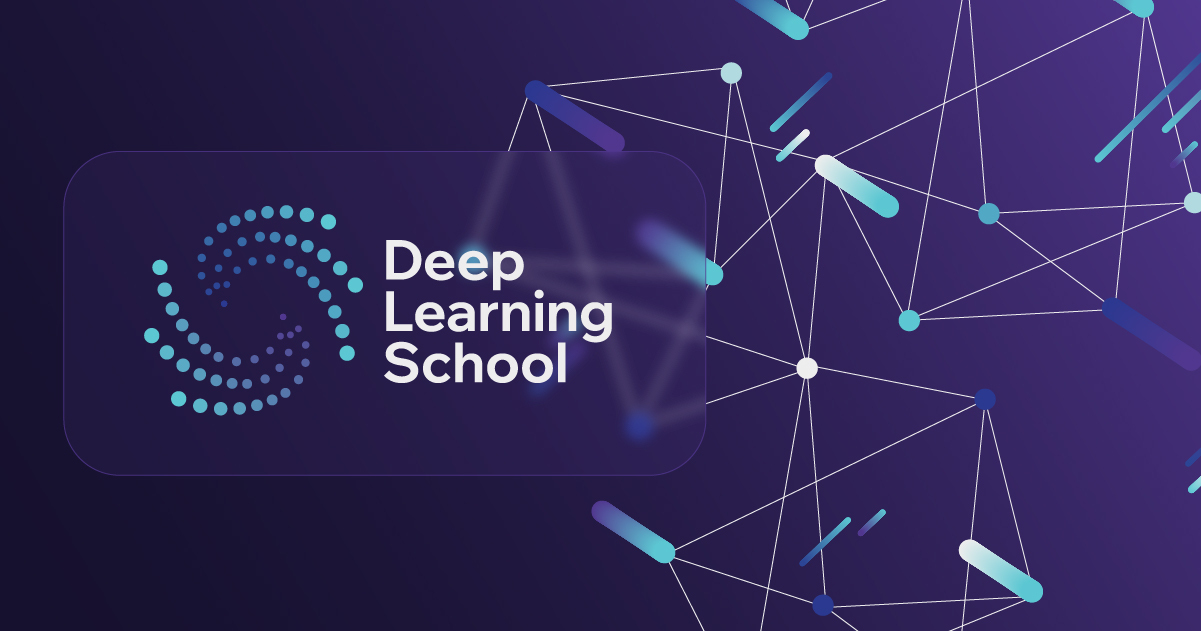

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [1]:
import math
from functools import partial
from collections import Counter, defaultdict

import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision

In [2]:
import torch
import numpy as np
import pandas as pd
import albumentations as A
import timm
import torch.nn as nn

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.anchor_utils import AnchorGenerator
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision

c:\Users\mserg\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [3]:
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

Создаем датасет для предобработки данных

In [4]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        # Вычитаем единицу чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Тут можно написать любые аугментации

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Добавляй сюда свои аугментации при необходимости!
        A.Normalize(mean=mean, std=std),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

Не забываем инициализировать наш датасет

In [6]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [7]:
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0", out_indices=(-1, -2, -3), unfreeze_last=1):
        """Создаёт бэкенд для модели.
        model_name: str Название модели из timm.list_models(pretrained=True)
        out_indices: List[int] Индексы слоёв, которые будут возвращены в `forward`.
        unfreeze_last: int Количество последних блоков, которые будут разморожены.
        """
        super().__init__()
        # timm.list_models(pretrained=True)
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)
        # Выключаем градиенты у модели, чтобы упростить обучение
        for param in self.backbone.parameters():
            param.requires_grad = False

        all_blocks = list(self.backbone.blocks)
        # Размораживаем последние `unfreeze_last` блоков
        for block in all_blocks[-unfreeze_last:]:
            for param in block.parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

Буду реализовывать FPN

In [8]:
class Neck(nn.Module):
    def __init__(self, in_channels_1, in_channels_2, in_channels_3, out_channels):
        """Создаёт neck для модели.
        in_channels_1: int Количество каналов на выходе из -1 слоя head.
        in_channels_2: int Количество каналов на выходе из -2 слоя head.
        in_channels_3: int Количество каналов на выходе из -3 слоя head.
        out_channels: int Количество каналов на выходе из neck.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels_1, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels_2, out_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels_3, out_channels, kernel_size=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        

    def forward(self, features):
        """features: List[Tensor] Список тензоров с фичами от head.
        Возвращает список из тензоров с фичами для head.
        """
        x1 = self.conv1(features[-1])
        x2 = self.conv2(features[-2])
        x3 = self.conv3(features[-3])

        x2 = self.upsample(x1) + x2
        x3 = self.upsample(x2) + x3
        result = [self.bn(self.conv(x1)), self.bn(self.conv(x2)), self.bn(self.conv(x3))]
        return result

### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

Буду реализовывать Decoupled Head

In [9]:
class Head(nn.Module):
    def __init__(self, num_anchors, in_channels, num_classes):
        """Создаёт head для модели.
        in_channels: int Количество каналов на входе в head.
        num_anchors: int Количество якорей на один пиксель.
        num_classes: int Количество классов в задаче.
        """
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels, 256, kernel_size=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=1)
        
        self.clsf = nn.Conv2d(256, num_anchors * num_classes, kernel_size=1)
        self.reg = nn.Conv2d(256, num_anchors * 4, kernel_size=1)
        self.iou = nn.Conv2d(256, num_anchors * 1, kernel_size=1)

        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.bn(self.conv2(x)))
        x = self.activation(self.conv3(x))

        clsf = self.clsf(x)
        reg = self.reg(x)
        iou = self.iou(x)

        return clsf, reg, iou

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [10]:
class Detector(nn.Module):
    """ Класс детектора, объединяющий все части вместе.

    Параметры
    ---------
    backbone_model_name : str
        Имя timm модели, которая будет исопльзоваться в качестве backbone
    neck_n_channels : int
        Итоговое количество каналов на выходе шеи
    num_classes : int
        Количество классов в датасете
    anchor_sizes : list, tuple
        Базовые размеры якорей. Используется методом `AnchorDetector` из
        `torchvision.models.detection.anchor_utils`для создания якорей.
    anchor_ratios : list, tuple
        Соотношения сторон якорей. Используется методом `AnchorDetector` из
        `torchvision.models.detection.anchor_utils`для создания якорей.
    input_size : tuple with length 2
        Размер входного изображения. Используется для расчета положения всех якорей.
    unfreeze_last : int
        Количество последних блоков, которые будут разморожены в backbone.

    NOTE: На самом деле, AnchorDetector на вход ждет anchor_sizes и anchor_ratios как Tuple[Tuple[int]],
    это связано с возможностью создания разных якорей для разных выходов модели. Сейчас нам это не нужно,
    поэтому структура намеренно упрощена.
    """
    def __init__(self,
                 backbone_model_name="efficientnet_b0",
                 neck_n_channels=256,
                 num_classes=4,
                 anchor_sizes=(32, 64, 128),
                 anchor_ratios=(0.5, 1.0, 2.0),
                 input_size=(640, 640),
                 unfreeze_last=1,
                 
        ):
        super().__init__()
        self.num_classes = num_classes
        # Создаем backbone с одним выходом, только из последнего слоя
        # Если нужно сделать несколько выходов, меняй out_indices
        self.backbone = Backbone(backbone_model_name, out_indices=(-1, -2, -3), unfreeze_last=unfreeze_last)
        # Получаем количество фичемапов на выходном слое
        in_channels_1 = self.backbone.backbone.feature_info.channels()[0]
        in_channels_2 = self.backbone.backbone.feature_info.channels()[1]
        in_channels_3 = self.backbone.backbone.feature_info.channels()[2]
        # Создаем шею, с учетом параметров, полученных выше
        self.neck = Neck(in_channels_1, in_channels_2, in_channels_3, out_channels=neck_n_channels)
        # Размерность выходов головы зависит от количество якорей, поэтому сначала считаем количество якорей в каждой
        # ячейке выходной фичемапы
        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        self.head = Head(num_anchors=num_anchors, in_channels=neck_n_channels, num_classes=num_classes)

        # Генерируем якоря
        anchor_generator = AnchorGenerator(sizes=(anchor_sizes, ), aspect_ratios=(anchor_ratios, ))
        # Узнаем размер выходной фичемапы
        reduction_1 = self.backbone.backbone.feature_info.reduction()[0]
        reduction_2 = self.backbone.backbone.feature_info.reduction()[1]
        reduction_3 = self.backbone.backbone.feature_info.reduction()[2]

        grid_sizes_1 = [[input_size[0] // reduction_1, input_size[1] // reduction_1]]
        grid_sizes_2 = [[input_size[0] // reduction_2, input_size[1] // reduction_2]]
        grid_sizes_3 = [[input_size[0] // reduction_3, input_size[1] // reduction_3]]

        # Расчитываем координаты якорей в каждой точке выходной фичемапы.
        ###
        # Якоря хранятся в формате (x_min, y_min, x_max, y_max)!
        ###
        anchors_1 = anchor_generator.grid_anchors(grid_sizes_1, strides=[[reduction_1, reduction_1]])
        anchors_1 = torch.stack(anchors_1, dim=0)

        anchors_2 = anchor_generator.grid_anchors(grid_sizes_2, strides=[[reduction_2, reduction_2]])
        anchors_2 = torch.stack(anchors_2, dim=0)

        anchors_3 = anchor_generator.grid_anchors(grid_sizes_3, strides=[[reduction_3, reduction_3]])
        anchors_3 = torch.stack(anchors_3, dim=0)
        # Заранее считаем координаты якорей в формате (x_center, y_center, w, h)
        # Это пригодится для расчета лосса
        anchor_centers_1 = (anchors_1[:, :, :2] + anchors_1[:, :, 2:]) / 2
        anchor_sizes_1 = (anchors_1[:, :, 2:] - anchors_1[:, :, :2])

        anchor_centers_2 = (anchors_2[:, :, :2] + anchors_2[:, :, 2:]) / 2
        anchor_sizes_2 = (anchors_2[:, :, 2:] - anchors_2[:, :, :2])

        anchor_centers_3 = (anchors_3[:, :, :2] + anchors_3[:, :, 2:]) / 2
        anchor_sizes_3 = (anchors_3[:, :, 2:] - anchors_3[:, :, :2])

        anchors = torch.cat([anchors_1, anchors_2, anchors_3], dim=1)
        anchor_centers = torch.cat([anchor_centers_1, anchor_centers_2, anchor_centers_3], dim=1)
        anchor_sizes = torch.cat([anchor_sizes_1, anchor_sizes_2, anchor_sizes_3], dim=1)
        #anchors = [anchors_1, anchors_2, anchors_3]
        #anchor_centers = [anchor_centers_1, anchor_centers_2, anchor_centers_3]
        #anchor_sizes = [anchor_sizes_1, anchor_sizes_2, anchor_sizes_3]


        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", anchor_centers)
        self.register_buffer("anchor_sizes", anchor_sizes)

    def forward(self, x):
        # Пропускаем картинку через всю сеть
        features = self.backbone(x)
        neck_features = self.neck(features)
        cls_logits_1, bbox_preds_1, iou_logits_1 = self.head(neck_features[0])
        cls_logits_2, bbox_preds_2, iou_logits_2 = self.head(neck_features[1])
        cls_logits_3, bbox_preds_3, iou_logits_3 = self.head(neck_features[2])

        # Преобразуем сырые выходы модели в формат, в котором будет удобно считать лосс
        # cls_logits - [N, NUM_ANCHORS * NUM_CLASSES, W, H]
        # bbox_preds - [N, NUM_ANCHORS * 4, W, H]
        # iou_logits - [N, NUM_ANCHORS * 1, W, H]
        N = x.shape[0]
        cls_logits_1 = cls_logits_1.permute(0, 2, 3, 1).contiguous()
        cls_logits_1 = cls_logits_1.view(N, -1, self.head.num_classes) # [N, NUM_ANCHORS * W * H, NUM_CLASSES]
        cls_logits_2 = cls_logits_2.permute(0, 2, 3, 1).contiguous()
        cls_logits_2 = cls_logits_2.view(N, -1, self.head.num_classes)
        cls_logits_3 = cls_logits_3.permute(0, 2, 3, 1).contiguous()
        cls_logits_3 = cls_logits_3.view(N, -1, self.head.num_classes)

        bbox_preds_1 = bbox_preds_1.permute(0, 2, 3, 1).contiguous()
        bbox_preds_1 = bbox_preds_1.view(N, -1, 4) # [N, NUM_ANCHORS * W * H, 4]

        iou_logits_1 = iou_logits_1.permute(0, 2, 3, 1).contiguous()
        iou_logits_1 = iou_logits_1.view(N, -1, 1) # [N, NUM_ANCHORS * W * H, 1]
        bbox_offsets_1 = bbox_preds_1
        confidence_logits_1 = iou_logits_1
        
        bbox_preds_2 = bbox_preds_2.permute(0, 2, 3, 1).contiguous()
        bbox_preds_2 = bbox_preds_2.view(N, -1, 4)

        iou_logits_2 = iou_logits_2.permute(0, 2, 3, 1).contiguous()
        iou_logits_2 = iou_logits_2.view(N, -1, 1) # [N, NUM_ANCHORS * W * H, 1]
        bbox_offsets_2 = bbox_preds_2
        confidence_logits_2 = iou_logits_2

        bbox_preds_3 = bbox_preds_3.permute(0, 2, 3, 1).contiguous()
        bbox_preds_3 = bbox_preds_3.view(N, -1, 4)

        iou_logits_3 = iou_logits_3.permute(0, 2, 3, 1).contiguous()
        iou_logits_3 = iou_logits_3.view(N, -1, 1) # [N, NUM_ANCHORS * W * H, 1]
        bbox_offsets_3 = bbox_preds_3
        confidence_logits_3 = iou_logits_3
        
        bbox_offsets = torch.cat([bbox_offsets_1, bbox_offsets_2, bbox_offsets_3], dim=1)
        confidence_logits = torch.cat([confidence_logits_1, confidence_logits_2, confidence_logits_3], dim=1)
        cls_logits = torch.cat([cls_logits_1, cls_logits_2, cls_logits_3], dim=1)

        #bbox_offsets = [bbox_offsets_1, bbox_offsets_2, bbox_offsets_3]
        #confidence_logits = [confidence_logits_1, confidence_logits_2, confidence_logits_3]
        #cls_logits = [cls_logits_1, cls_logits_2, cls_logits_3]

        if self.training:
            # В процессе тренировки возвращаем просто смещения и логиты
            return bbox_offsets, confidence_logits, cls_logits

        # Если мы делаем предсказание, сразу считаем итоговый ббокс и вероятности
        # Модель предсказывает ббоксы в формате (x_min, y_min, w, h)
        #for i in range(3):
        #    bbox_offsets[i] = self.decode_bboxes(bbox_offsets[i])
        #    confidence_logits[i] = torch.sigmoid(confidence_logits[i])
        #    cls_logits[i] = torch.softmax(cls_logits[i], dim=-1)

        bboxes = self.decode_bboxes(bbox_offsets)
        confidence = torch.sigmoid(confidence_logits)
        cls_probs = torch.softmax(cls_logits, dim=-1)
        return bboxes, confidence, cls_probs
    
    
    def decode_bboxes(self, bbox_offsets):
        """Используя предсказанные смещения, считаем предсказанные ббоксы по формулам из YOLOv3.

        Боксы возвращаются в формате (x_min, y_min, w, h).
        """
        tx = bbox_offsets[:, :, 0]
        ty = bbox_offsets[:, :, 1]
        tw = bbox_offsets[:, :, 2]
        th = bbox_offsets[:, :, 3]

        center_x = self.anchor_centers[:, :, 0] + torch.sigmoid(tx) * self.anchor_sizes[:, :, 0]
        center_y = self.anchor_centers[:, :, 1] + torch.sigmoid(ty) * self.anchor_sizes[:, :, 1]

        w = torch.exp(tw) * self.anchor_sizes[:, :, 0]
        h = torch.exp(th) * self.anchor_sizes[:, :, 1]

        x_min = center_x - w / 2
        y_min = center_y - h / 2
        return torch.stack([x_min, y_min, w, h], dim=-1)

## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [ ]:
from torchvision.ops import box_iou

def get_target_offset(anchor, gt):
    """ Вычисляет смещения (dx, dy, dw, dh) между якорем и GT боксом """
    anchor_center_x = (anchor[0] + anchor[2]) / 2
    anchor_center_y = (anchor[1] + anchor[3]) / 2
    anchor_w = anchor[2] - anchor[0]
    anchor_h = anchor[3] - anchor[1]

    gt_center_x = (gt[0] + gt[2]) / 2
    gt_center_y = (gt[1] + gt[3]) / 2
    gt_w = gt[2] - gt[0]
    gt_h = gt[3] - gt[1]

    dx = (gt_center_x - anchor_center_x) / anchor_w
    dy = (gt_center_y - anchor_center_y) / anchor_h
    dw = torch.log(gt_w / anchor_w)
    dh = torch.log(gt_h / anchor_h)

    return torch.tensor([dx, dy, dw, dh], device=anchor.device)

def assign_target_tal(anchors, gt_boxes, gt_labels, num_classes, pred_scores, alpha=6.0, beta=1.0, top_k=5, pos_th=0.6, neg_th=0.3):
    num_anchors = anchors.shape[0]
    device = anchors.device
    target_objectness = torch.zeros(num_anchors, device=device)
    target_offsets = torch.zeros((num_anchors, 4), device=device)
    target_cls = torch.zeros((num_anchors, num_classes), device=device)

    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls


    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] += gt_xyxy[:, :2]

    ious = box_iou(anchors, gt_xyxy)  # [num_anchors, num_gt]
    num_gt = gt_xyxy.shape[0]

    center_x = (anchors[:, 0] + anchors[:, 2]) / 2
    center_y = (anchors[:, 1] + anchors[:, 3]) / 2


    selected_pairs = torch.zeros((num_anchors, num_gt), dtype=torch.bool, device=device)

    for gt_idx in range(num_gt):
        gt_box = gt_xyxy[gt_idx]
        x1, y1, x2, y2 = gt_box
        in_gt = (center_x >= x1) & (center_x <= x2) & (center_y >= y1) & (center_y <= y2)
        candidate_indices = torch.where(in_gt)[0]

        if len(candidate_indices) == 0:
            best_anchor = ious[:, gt_idx].argmax()
            selected_pairs[best_anchor, gt_idx] = True
            continue

        scores = pred_scores[candidate_indices, gt_labels[gt_idx]]
        iou_vals = ious[candidate_indices, gt_idx]
        t_values = (scores ** alpha) * (iou_vals ** beta)

        k = min(top_k, len(candidate_indices))
        topk_indices = torch.topk(t_values, k=k).indices
        selected_indices = candidate_indices[topk_indices]
        selected_pairs[selected_indices, gt_idx] = True

    for anchor_idx in range(num_anchors):
        gt_matches = torch.where(selected_pairs[anchor_idx])[0]
        if len(gt_matches) == 0:
            continue
        best_gt = gt_matches[ious[anchor_idx, gt_matches].argmax()]
        selected_pairs[anchor_idx, :] = False
        selected_pairs[anchor_idx, best_gt] = True

    for gt_idx in range(num_gt):
        if not selected_pairs[:, gt_idx].any():
            best_anchor = ious[:, gt_idx].argmax()
            selected_pairs[best_anchor, gt_idx] = True

    pos_anchors, pos_gt = selected_pairs.nonzero(as_tuple=True)
    for anchor, gt in zip(pos_anchors, pos_gt):
        gt_box = gt_xyxy[gt]
        anchor_box = anchors[anchor]
        target_offsets[anchor] = get_target_offset(anchor_box, gt_box)
        target_objectness[anchor] = 1
        target_cls[anchor, gt_labels[gt]] = 1

    best_iou, _ = ious.max(dim=1)
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th) & (target_objectness == 0)
    target_objectness[ignore_mask] = -1

    return target_offsets, target_objectness, target_cls

### DIoU [1]



Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>


In [12]:
from torchvision.ops import distance_box_iou_loss

In [13]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [14]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [15]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean").item()}")

 DIoU: 1.0180869102478027


In [16]:
def diou_loss(pred_boxes, gt_boxes, eps=1e-7):
    """
    Вычисляет DIoU loss между предсказанными и истинными bounding boxes.

    Параметры:
    ----------
    pred_boxes : torch.Tensor, shape (N, 4)
        Предсказанные боксы в формате (x1, y1, x2, y2)
    gt_boxes : torch.Tensor, shape (N, 4)
        Истинные боксы в формате (x1, y1, x2, y2)
    eps : float
        Малое число для предотвращения деления на ноль

    Возвращает:
    ---------
    torch.Tensor
        Среднее значение DIoU loss по батчу
    """

    # 1. Площади боксов
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]).clamp(min=0) * \
                (pred_boxes[:, 3] - pred_boxes[:, 1]).clamp(min=0)
    gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]).clamp(min=0) * \
              (gt_boxes[:, 3] - gt_boxes[:, 1]).clamp(min=0)

    # 2. Координаты пересечения
    inter_x1 = torch.max(pred_boxes[:, 0], gt_boxes[:, 0])
    inter_y1 = torch.max(pred_boxes[:, 1], gt_boxes[:, 1])
    inter_x2 = torch.min(pred_boxes[:, 2], gt_boxes[:, 2])
    inter_y2 = torch.min(pred_boxes[:, 3], gt_boxes[:, 3])

    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter_area = inter_w * inter_h

    # 3. IoU
    union_area = pred_area + gt_area - inter_area + eps
    iou = inter_area / union_area

    # 4. Координаты выпуклой оболочки
    c_x1 = torch.min(pred_boxes[:, 0], gt_boxes[:, 0])
    c_y1 = torch.min(pred_boxes[:, 1], gt_boxes[:, 1])
    c_x2 = torch.max(pred_boxes[:, 2], gt_boxes[:, 2])
    c_y2 = torch.max(pred_boxes[:, 3], gt_boxes[:, 3])

    c_w = (c_x2 - c_x1).clamp(min=eps)
    c_h = (c_y2 - c_y1).clamp(min=eps)
    c_diag = c_w ** 2 + c_h ** 2

    # 5. Расстояние между центрами боксов
    pred_center_x = (pred_boxes[:, 0] + pred_boxes[:, 2]) / 2
    pred_center_y = (pred_boxes[:, 1] + pred_boxes[:, 3]) / 2
    gt_center_x = (gt_boxes[:, 0] + gt_boxes[:, 2]) / 2
    gt_center_y = (gt_boxes[:, 1] + gt_boxes[:, 3]) / 2

    center_dist = (pred_center_x - gt_center_x) ** 2 + (pred_center_y - gt_center_y) ** 2

    # 6. DIoU loss
    diou = 1 - iou + center_dist / c_diag

    return diou.mean()

In [17]:
diou_loss(pred_boxes, true_boxes)

tensor(1.0181)

In [18]:
import numpy as np
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

In [19]:
class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    bbox_loss : Локализационная часть лосса
    obj_loss : Лосс для Confidence score
    cls_loss : Классификационная часть лосса
    weight_bbox, weight_obj, weight_cls : Константы для баллансировки частей лосса
    """
    def __init__(self,
            bbox_loss=None, obj_loss=None, cls_loss=None,
            weight_bbox=5, weight_obj=1, weight_cls=1
        ):
        self.bbox_loss = nn.SmoothL1Loss() if bbox_loss is None else bbox_loss
        self.obj_loss = nn.BCEWithLogitsLoss() if obj_loss is None else obj_loss
        self.cls_loss = nn.BCEWithLogitsLoss() if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Предсказания модели для одной картинки: Смещения, objectness score и логиты для классов
        targets : Gt значения для расчета лосса, а именно: GT смещения, GT objectness score и GT ohe классы
        """
        pred_offsets, pred_obj_logits, pred_cls_logits = predicts
        target_boxes, target_obj, target_cls = targets
        target_obj = target_obj.unsqueeze(-1)
        # Confidence score считается только для предсказаний соотв отрицательным и положительным якорям
        valid_mask = target_obj != -1
        loss_obj = self.obj_loss(pred_obj_logits[valid_mask], target_obj[valid_mask])

        # Локализационная и классификационные части считаются для предсказаинй соотв положительным якорям
        pos_mask = target_obj == 1
        pos_mask = pos_mask.squeeze(-1)
        
        if pos_mask.sum() > 0:
            loss_cls = self.cls_loss(pred_cls_logits[pos_mask], target_cls[pos_mask])
            loss_bbox = self.bbox_loss(pred_offsets[pos_mask], target_boxes[pos_mask], reduction='mean')
        else:
            loss_cls = torch.tensor(0.0, device=pred_offsets.device)
            loss_bbox = torch.tensor(0.0, device=pred_offsets.device)

        return self.weight_bbox * loss_bbox + self.weight_obj * loss_obj + self.weight_cls * loss_cls

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [20]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    assign_target_method : callable, который решает задачу сопоставления якорей и таргета (например, assign_target)
    device : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    assign_target_kwargs : доп параметры для функции в `assign_target_method`,
    val_dataloader : torch dataloader загружающий валидационные данные.
    score_threshold : При расчете метрики на валидации, все предсказания,
        с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.
    """
    def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            outputs = self.model(images)

            anchors = self.model.anchors.view(-1, 4)
            #anchors = self.model.anchors
            accum_loss = 0.0
            for ix in range(images.shape[0]):
                gt_boxes = targets[ix]['boxes'].to(self.device)
                gt_labels = targets[ix]['labels'].to(self.device)
                # выбираем какие якоря будут использоваться при расчете лосса.
                #assigned_targets = self.assign_target_method(anchors, gt_boxes, gt_labels, pred_scores=outputs[ix][2],
                #                                             num_classes=self.model.num_classes)
                assigned_targets = assign_target_tal(anchors, gt_boxes, gt_labels, pred_scores=outputs[2][ix],
                                                       num_classes=4)
                # Считаем лосс на основании предсказаний модели и таргетов.
                outputs_ixs = [out[ix] for out in outputs]
                loss = self.compute_loss(outputs_ixs, assigned_targets)
                accum_loss += loss
            accum_loss = accum_loss / images.shape[0]
            batch_loss.append(accum_loss.cpu().detach().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            accum_loss.backward()
            self.optimizer.step()
        # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric:.4}"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()
            torch.save(self.model.state_dict(), f'New_2_My_yolo_{epoch}_epoch.pt')

    @torch.no_grad()
    def validate(self, dataloader=None):
        """ Метод для валидации модели. Если dataloader не передан, будет использоваться self.val_dataloder.
        Возвращает mAP (0.5 ... 0.95).
        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader
        # Считаем метрику mAP с помощью функции из torchmetrics
        metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox")
        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)
            outputs = self.model(images)
            predicts = _filter_predictions(outputs, self.score_threshold, self.nms_threshold,
                                       max_boxes_per_cls=self.max_boxes_per_cls, return_type="torch")
            metric.update(predicts, targets)
        return metric.compute()["map"].item()

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            ax[1].plot(np.arange(self.val_every, len(self.batch_loss)+1, len(self.val_dataloader) * self.val_every),
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")
            ax[1].grid()
            ax[1].set_title("Valiation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
        plt.legend()
        plt.show()

def _filter_predictions(predictions, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type="list"):
    """ Ббоксы в `predictions` должны быть в формате (x_min, y_min, w, h). """
    # Итоговый скор считается как произведение уверенности модели в том что в данном якоре
    # и вероятность каждого класса в данном якоре.
    bboxes, confidences, cls_probs = predictions
    all_final_scores = confidences * cls_probs

    num_classes = cls_probs.shape[-1]
    final_predictions = []
    # Для каждого элемента в `predictions` независимо выбираем ббоксы и скоры
    for boxes, final_scores in zip(bboxes, all_final_scores):
        preds = {"boxes": [], "labels": [], "scores": []}

        # Для каждого класса отдельно фильтруем ббоксы с помощью NMS
        for cls in range(num_classes):
            cls_scores = final_scores[:, cls]
            # Фильтруем ббоксы, score которых меньше порога
            keep_ixs = cls_scores > score_threshold
            if keep_ixs.sum() == 0:
                continue
            cls_boxes = boxes[keep_ixs]
            cls_scores = cls_scores[keep_ixs]

            # Если предсказаний слишком много, выбираем только самые уверенные
            if len(cls_boxes) > max_boxes_per_cls:
                pos = torch.argsort(cls_scores, descending=True)
                cls_boxes = cls_boxes[pos[:max_boxes_per_cls]]
                cls_scores = cls_scores[pos[:max_boxes_per_cls]]

            # Конвертируем ббоксы в формат x_min, y_min, x_max, y_max
            boxes_xyxy = cls_boxes.clone()
            boxes_xyxy[:, 2:] = boxes_xyxy[:, :2] + boxes_xyxy[:, 2:]
            # Запускаем NMS по всем оставшимся ббоксам класса cls
            pred_ixs = nms(boxes_xyxy, cls_scores, nms_threshold)
            # Сохраняем все предсказания для класса cls
            for ix in pred_ixs:
                preds["boxes"].append(cls_boxes[ix].cpu().tolist())
                preds["labels"].append(cls)
                preds["scores"].append(cls_scores[ix].item())
        if return_type == "torch":
            for key, item in preds.items():
                preds[key] = torch.tensor(item)
        elif return_type != "list":
            raise ValueError(f"Received unexpected `return_type`. Could be either `torch` or `list`, not {return_type}")
        final_predictions.append(preds)
    return final_predictions

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=9, shuffle=False, collate_fn=collate_fn)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3

model = Detector("efficientnet_b0", num_classes=4, anchor_sizes=(30, 50, 140, 300), anchor_ratios=(0.5, 1, 1.6, 2)).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-5)

bce_loss = nn.BCEWithLogitsLoss()
smooth_l1_loss = nn.SmoothL1Loss()
diou = distance_box_iou_loss
compute_loss = ComputeLoss(diou, bce_loss, bce_loss, weight_bbox=10)

runner = Runner(model, compute_loss, optimizer, train_dataloader, assign_target_tal, device=device,
                 scheduler=scheduler,
                 val_dataloader=test_dataloader)

num_epochs = 7

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [23]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [24]:
runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/15 [00:00<?, ?it/s]

In [45]:
model.load_state_dict(torch.load('New_2_My_yolo_4_epoch.pt'))

<All keys matched successfully>

In [28]:
import gc

torch.cuda.ipc_collect()  # собирает неиспользуемые блоки
gc.collect()
torch.cuda.empty_cache()

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

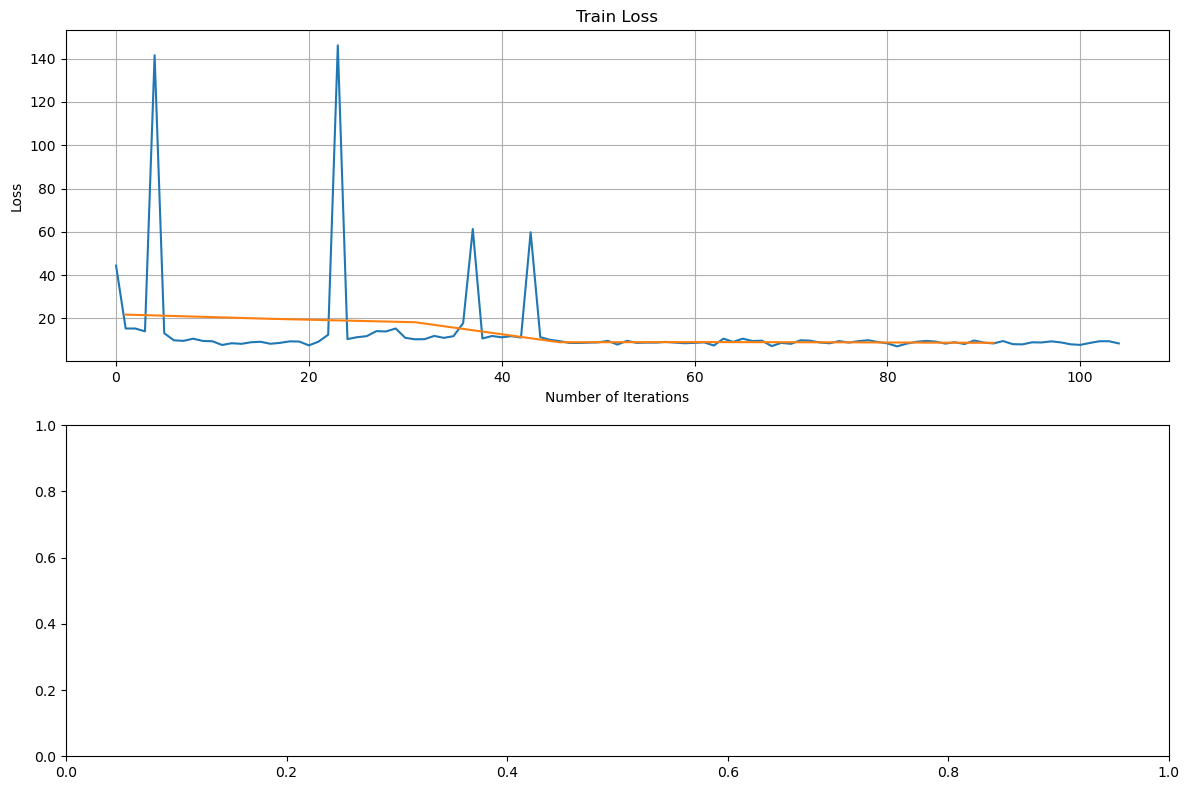

In [26]:
runner.plot_loss(row_figsize=4)

In [ ]:

# Место для обучения, валидации и экспериментов!


Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [27]:
# Определяем константы для цвета и названий классов
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

In [28]:
@torch.no_grad()
def predict(model, images, device, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type='list'):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)
    final_predictions =  _filter_predictions(outputs, score_threshold=score_threshold, nms_threshold=nms_threshold,
                                             max_boxes_per_cls=max_boxes_per_cls, return_type=return_type)
    return final_predictions

In [29]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

def plot_examples(df, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)
    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image = Image.open(io.BytesIO(row['image']['bytes']))
        bboxes = row["objects"]['bbox']
        classes = row["objects"]['category']
        img = np.array(image)
        for bbox, label in zip(bboxes, classes):
            color = class_to_color[label]
            class_name = class_to_name[label]
            img = add_bbox(img, bbox, label=str(class_name), color=color)
        ax.imshow(img)
        ax.set_title(f"Image id: {row['image_id']}")
        ax.set_xticks([])
        ax.set_yticks([])

In [30]:
def plot_predictions(images, predictions, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))
            preds = predictions[ix + i]
            for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
                color = class_to_color[label+1]
                label = class_to_name[label+1]
                img = add_bbox(img, bbox, label=f"Class {label}: {score:.2f}", color=color)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

In [39]:
test_iter = iter(test_dataloader)

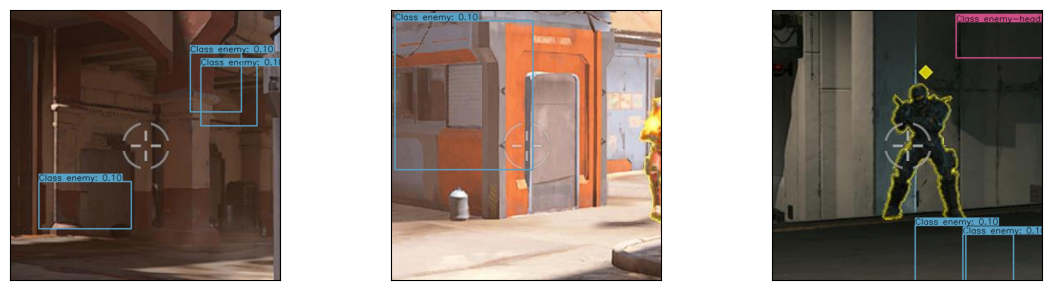

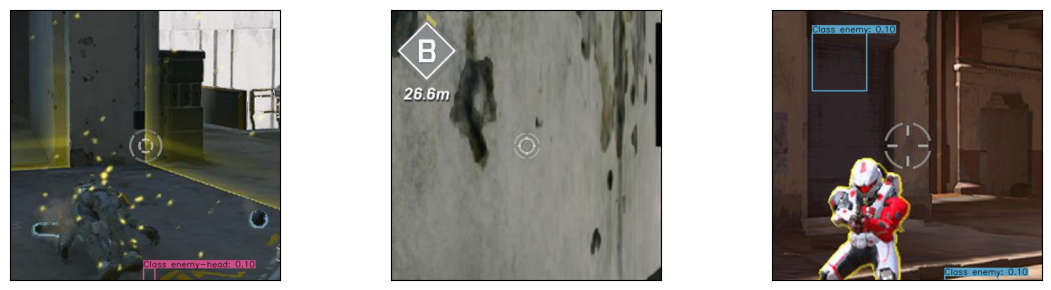

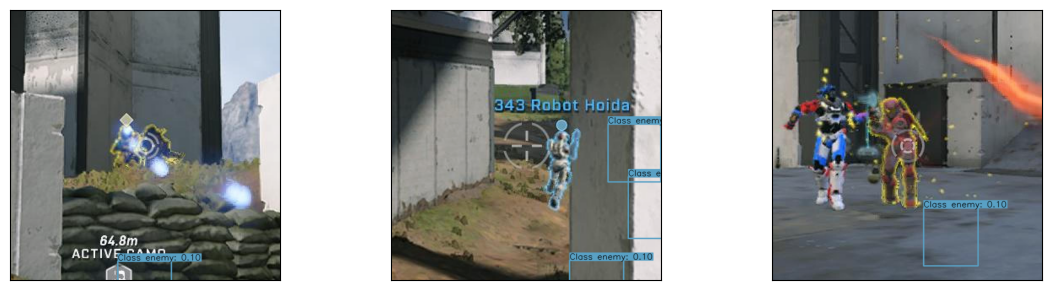

In [53]:
score_threshold = 0.1
nms_threshold = 0.5

images, _ = next(test_iter)
preds = predict(model, images, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)
plot_predictions(images, preds)

Короче ерундой мается модель, хз че не так с ней, устал уже возиться. Чем выше эпоха, тем меньше модель уверенна в своих предсказаниях

In [55]:
model.load_state_dict(torch.load('New_2_My_yolo_7_epoch.pt'))

<All keys matched successfully>

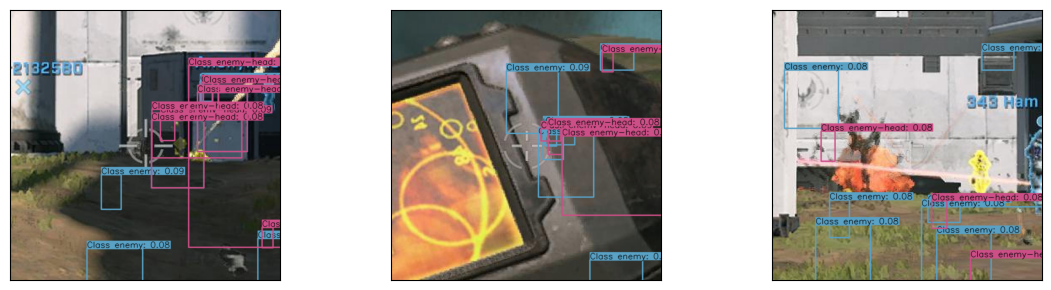

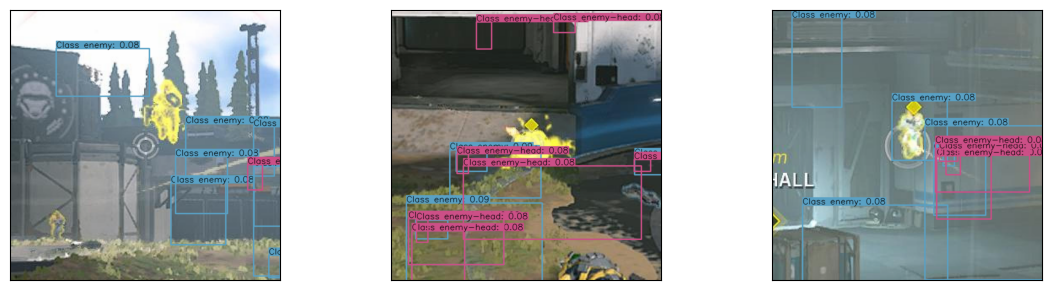

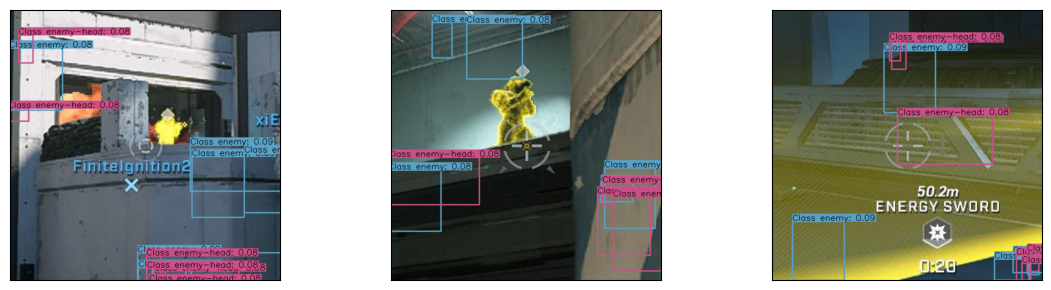

In [61]:
score_threshold = 0.08
nms_threshold = 0.4

images, _ = next(test_iter)
preds = predict(model, images, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)
plot_predictions(images, preds)

In [62]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def compute_coco_map(model, dataloader, device, score_threshold=0.01, nms_threshold=0.5, num_classes=4):
    """ Считаем mAP модели на данных из `dataloader`. """
    model.eval()
    ann_id = 1
    all_detections = []
    all_gt_annotations = []
    images_info = []

    for images, targets in tqdm(dataloader, desc="Dataset Evaluation"):
        # Делаем предсказание для всех картинок в батче
        predictions = predict(model, images, device, score_threshold, nms_threshold)
        # Сохраняем изначальные картинки, предсказания и таргет в формате COCO
        for i in range(images.shape[0]):
            image_id = targets[i]["image_id"]
            images_info.append({
                "id": image_id,
                "width": images[i].shape[1],
                "height": images[i].shape[2]
            })

            # Сохраняем предсказания модели в формате COCO
            img_pred = predictions[i]
            for box, cls, sc in zip(img_pred["boxes"], img_pred["labels"], img_pred["scores"]):
                detection = {
                    "image_id": image_id,
                    "category_id": cls + 1,  # Классы в COCO начинаются с 1
                    "bbox": list(box),  # Бокс в COCO формате [x, y, w, h]
                    "score": sc
                }
                all_detections.append(detection)

            # Сохраняем таргет в формате COCO
            gt_boxes = targets[i]['boxes'].cpu().numpy().tolist()
            gt_labels = targets[i]['labels'].cpu().numpy().tolist()
            for box, label in zip(gt_boxes, gt_labels):
                gt_annotation = {
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": label + 1,
                    "bbox": box,
                    "area": box[2] * box[3],
                    "iscrowd": 0
                }
                all_gt_annotations.append(gt_annotation)
                ann_id += 1

    coco_gt_dict = {
        "images": images_info,
        "annotations": all_gt_annotations,
        "categories": [{"id": i+1, "name": f"class_{i}"} for i in range(model.num_classes)]
    }

    coco_gt = COCO()
    coco_gt.dataset = coco_gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(all_detections)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    overall_mAP = coco_eval.stats[0]
    print(f"Validation mAP: {overall_mAP:.4f}\n\n")

    class_maps = {}
    for cat_id in range(1, num_classes + 1):
        class_name = class_to_name[cat_id]
        print(f"\nmAP for class {class_name}")
        print("-" * 50)
        coco_eval_cat = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval_cat.params.catIds = [cat_id]
        coco_eval_cat.params.imgIds = coco_gt.getImgIds(catIds=[cat_id])
        coco_eval_cat.evaluate()
        coco_eval_cat.accumulate()
        coco_eval_cat.summarize()
        ap = coco_eval_cat.stats[0]
        class_maps[cat_id] = ap

In [64]:
score_threshold = 0.08
nms_threshold = 0.4
compute_coco_map(model, test_dataloader, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)

Dataset Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.5

Короче вот такие пироги. Не получилось забороть yolo